**Building a Random Forest Model for NYC TLC**

$Task:$ Build a Machine Learning model to predict if a customer will not leave a tip.

$Purpose:$ To find ways to generate more revenue for taxi cab drivers.

$Goal:$ To predict whether or not a customer is a generous tipper.

**1. Import and data loading**

In [1]:
# Import packages and libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
# Changing the setting to see all the columns.
pd.set_option('display.max_columns', None)

There are two dataframes: 

One containing the original data. 

The other containing the mean durations, mean distances, and predicted fares from the MLR notebook.

In [3]:
# Import datasets
get_cwd = os.getcwd()
datafolder = os.path.join(get_cwd, 'Dataset')

# Load dataset into dataframe
df0 = pd.read_csv(datafolder + '/2017_Yellow_Taxi_Trip_Data.csv')

# Import predicted fares and mean distance and duration
nyc_preds_means = pd.read_csv(datafolder + '/nyc_preds_means.csv')

In [4]:
# Inspect the first few rows of df0
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [5]:
# Inspect the first few rows of `nyc_preds_means`
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


Joining the two dataframes

In [6]:
# Merge datasets
df0_merged = df0.merge(nyc_preds_means, left_index=True, right_index=True)

df0_merged.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


**2. Feature Engineering**

In [7]:
# Info of the merged dataset
df0_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

We know from your EDA that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, we'll need to sample the data to select only the customers who pay with credit card.

In [8]:
# Subset the data to isolate only customers who paid by credit card
df1 = df0_merged[df0_merged['payment_type'] == 1]

**target**
We have to create a tip percent column whch will be needed to create the target variable.

Add a `tip_percent` column to the dataframe by performing the following calculation:

`tip_percent` = `tip_amount`/(`total_amount` - `tip_amount)`

Round the result to three places beyond the decimal.

In [9]:
# Create tip % col
df1['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 3)

C:\Users\222817\AppData\Local\Temp\ipykernel_19976\1025802444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 3)


Now create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

In [10]:
# Create 'generous' col (target)
df1['generous'] = df1['tip_percent']
df1['generous'] = (df1['generous'] >= 0.2)
df1['generous'] = df1['generous'].astype(int)

C:\Users\222817\AppData\Local\Temp\ipykernel_19976\53023181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['generous'] = df1['tip_percent']
C:\Users\222817\AppData\Local\Temp\ipykernel_19976\53023181.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['generous'] = (df1['generous'] >= 0.2)
C:\Users\222817\AppData\Local\Temp\ipykernel_19976\53023181.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Create day column

In [11]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'])
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'])

C:\Users\222817\AppData\Local\Temp\ipykernel_19976\3174213170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'])
C:\Users\222817\AppData\Local\Temp\ipykernel_19976\3174213170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'])


In [12]:
# Create a 'day' col
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

C:\Users\222817\AppData\Local\Temp\ipykernel_19976\918047604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()


Create time of day columns

Next, we will engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = 06:00 to 10:00

`daytime` = 10:00 to 16:00

`pm_rush` = 16:00 to 20:00

`nighttime` = 20:00 to 06:00

In [13]:
# Create 'am_rush' col
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour

C:\Users\222817\AppData\Local\Temp\ipykernel_19976\986325379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour
C:\Users\222817\AppData\Local\Temp\ipykernel_19976\986325379.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour
C:\Users\222817\AppData\Local\Temp\ipykernel_19976\986325379.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [14]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

In [15]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)

C:\Users\222817\AppData\Local\Temp\ipykernel_19976\1819868534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['am_rush'] = df1.apply(am_rush, axis=1)


In [16]:
# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

In [17]:
# Apply 'daytime()' function to the 'daytime' series
df1['daytime'] = df1.apply(daytime, axis=1)

C:\Users\222817\AppData\Local\Temp\ipykernel_19976\371366598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['daytime'] = df1.apply(daytime, axis=1)


In [18]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [19]:
# Apply 'pm_rush()' function to the 'pm_rush' series
df1['pm_rush'] = df1.apply(pm_rush, axis=1)

C:\Users\222817\AppData\Local\Temp\ipykernel_19976\1223649407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['pm_rush'] = df1.apply(pm_rush, axis=1)


In [20]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [21]:
# Apply 'nighttime' function to the 'nighttime' series
df1['nighttime'] = df1.apply(nighttime, axis=1)
df1.head()

C:\Users\222817\AppData\Local\Temp\ipykernel_19976\2537633290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['nighttime'] = df1.apply(nighttime, axis=1)


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,1,0,0,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,0,1,0,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,1,0,0,0
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,sunday,0,1,0,0
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,saturday,0,0,0,1


Create month column

In [22]:
# Create 'month' col
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

C:\Users\222817\AppData\Local\Temp\ipykernel_19976\2202272965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()


Drop Columns

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed.

In [23]:
df1.columns

Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'mean_duration', 'mean_distance', 'predicted_fare', 'tip_percent',
       'generous', 'day', 'am_rush', 'daytime', 'pm_rush', 'nighttime',
       'month'],
      dtype='object')

In [24]:
# Drop columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'store_and_fwd_flag', 
             'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
             'tolls_amount', 'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int64(10), object(2)
memory usage: 1.9+ MB


Variable encoding

Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations.

In [25]:
# 1. Define list of cols to convert to string
cols_to_list = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_list:
    df1[col] = df1[col].astype('str')

In [26]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 347 entries, passenger_count to month_sep
dtypes: bool(338), float64(3), int64(6)
memory usage: 6.1 MB


Evaluation metric

Examine the class balance of your target variable. 

In [27]:
# Get class balance of 'generous' col
df2['generous'].value_counts(normalize=True)

generous
1    0.526368
0    0.473632
Name: proportion, dtype: float64

A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

F1 score is the metric that places equal weight on true positives and false positives, and so therefore on precision and recall.

**3. Modelling**

Now we're ready to model. The only remaining step is to split the data into features/target variable and training/testing data. 

1. Target variable `y` is `generous`
2. Isolate the featuers in variable `X`
3. Split the data into training and testing sets. Put 20% of the samples into the test set, stratify the data, and set the random state.

In [28]:
# Isolate target variable (y)
y = df2['generous']

# Isolate the features (X)
X = df2.drop('generous', axis = 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

$RandomForest$

In [29]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune 
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }

# 3. Define a set of scoring metrics to capture
scoring = ['accuracy', 'f1', 'precision','recall']

# 4. Instantiate the GridSearchCV object

rf1 = GridSearchCV(rf, cv_params, scoring = scoring, cv = 4, refit = 'f1')

In [30]:
#Fit the model
rf1.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring=['accuracy', 'f1', 'precision', 'recall'])

In [31]:
# Define a path to the folder where you want to save the model
path = get_cwd

In [32]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [33]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [34]:
# Examine best score
rf1.best_score_

np.float64(0.7207948286405815)

In [35]:
# Examine the best combination of hyperparameters
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

The `make_results()` function puts the output all of the scores of your model in a table.

In [36]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [37]:
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.679793,0.767111,0.720795,0.685146


In [38]:
# Get scores on test data
rf_preds = rf1.best_estimator_.predict(X_test)

The `get_test_scores()` function will output the scores of the model on the test data.

In [39]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [40]:
# Get scores on test data
rf_test_scores = get_test_scores("RF test", rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.679793,0.767111,0.720795,0.685146
0,RF test,0.658172,0.759591,0.705254,0.674746


All scores increased by at most ~0.02.

$XGBoost$

Now, we try to improve the scores using the XGBoost model.

In [41]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state = 0)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]}

# 3. Define a set of scoring metrics to capture
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}

# 4. Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv = 4, refit = 'f1')

In [42]:
#Fit the model
xgb1.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [43]:
# Examine best score
xgb1.best_score_

np.float64(0.7015491167766134)

In [44]:
# Examine best parameters
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

In [45]:
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.679793,0.767111,0.720795,0.685146
0,RF test,0.658172,0.759591,0.705254,0.674746
0,XGB CV,0.674793,0.730643,0.701549,0.670652


In [46]:
# Get scores on test data
xgb_preds = xgb1.best_estimator_.predict(X_test)

In [47]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis = 0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.679793,0.767111,0.720795,0.685146
0,RF test,0.658172,0.759591,0.705254,0.674746
0,XGB CV,0.674793,0.730643,0.701549,0.670652
0,XGB test,0.652198,0.739770,0.693229,0.664592


The F1 score is ~0.01 lower than the random forest model. Both models are acceptable, but the random forest model is the champion.

Plot a confusion matrix of the model's predictions on the test data.

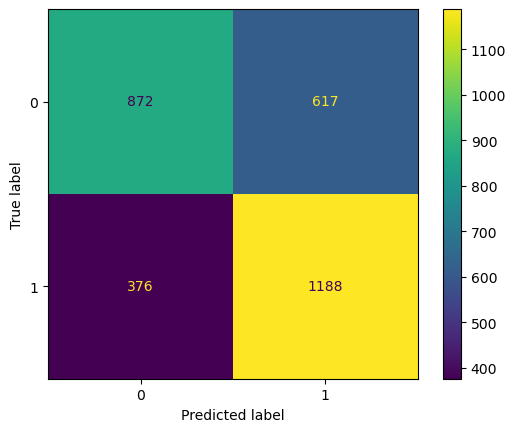

In [48]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels = rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf1.classes_)

disp.plot(values_format='')

Feature importance

In [49]:
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index = X_test.columns)
rf_importances = rf_importances.sort_values(ascending = False)[:15]

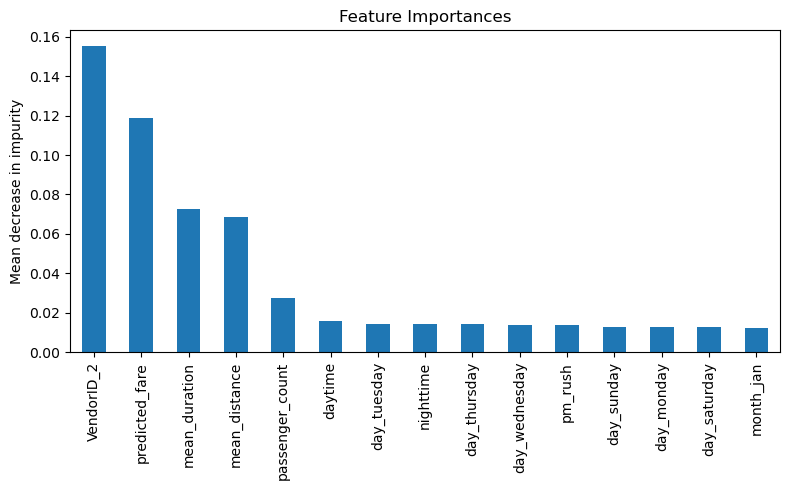

In [50]:
fig, ax = plt.subplots(figsize = (8, 5))
rf_importances.plot.bar(ax = ax)
ax.set_title('Feature Importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

**Conclusion**

The model performs acceptably. Its F1 score was 0.7235 and it had an overall accuracy of 0.6865. It correctly identified ~78% of the actual responders in the test set, which is 48% better than a random guess.

Unfortunately, random forest is not the most transparent machine learning algorithm. We know that `VendorID`, `predicted_fare`, `mean_duration`, and `mean_distance` are the most important features, but we don't know how they influence tipping. This would require further exploration. It is interesting that `VendorID` is the most predictive feature. This seems to indicate that one of the two vendors tends to attract more generous customers. It may be worth performing statistical tests on the different vendors to examine this further.